In [20]:
import pandas as pd
import numpy as np

import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

import sys

import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display


from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier


from IPython.display import Audio

from utils.audio_preprocess import *
from utils.septr import SeparableTr
from utils.feature_exctraction_v2 import get3d_data, png_processing
from utils. post_analysis import *

In [21]:
from tqdm import tqdm

In [22]:
import keras
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D,MaxPooling2D, Flatten, Dropout, BatchNormalization, Input
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.optimizers.legacy import Adam 

#import warnings
#if not sys.warnoptions:
#    warnings.simplefilter("ignore")
#warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [23]:
# # ave maria 🙏🏻🙏🏿
from scikeras.wrappers import KerasClassifier

In [24]:
data_path = data_path()

In [25]:
#train, test = train_test_split(data_path, random_state=42, shuffle=True)

In [26]:
x_train, y_train, x_test, y_test, encoder = get3d_data(data_path, feats = True, max_aug = 3, save_png=False)

Exctracting and processing data...
Train exctraction complete. x_train -> 21356
Test exctraction complete. x_test -> 2830
Final processing for NN.
x_train.shape ->  (21356, 17, 400, 1)
y_train.shape ->  (21356, 6)
x_test.shape ->  (2830, 17, 400, 1)
y_test.shape ->  (2830, 6)
Done.


In [8]:
#xpng_train, xpng_test = png_processing()

In [9]:
#np.save('x_train.npy', x_train)
#np.save('y_train.npy', y_train)
#np.save('x_test.npy', x_test)
#np.save('y_test.npy', y_test)

In [10]:
# scaling our data with sklearn's Standard scaler
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

### Dense NN

In [29]:
large_base_model = Sequential()
large_base_model.add(Input(shape=x_train.shape[1:], batch_size=128))  # input
large_base_model.add(Flatten())

large_base_model.add(Dense(units=184, activation="relu"))
large_base_model.add(Dropout(0.2))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=256, activation="relu"))
large_base_model.add(Dropout(0.2))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=512, activation="relu"))
large_base_model.add(Dropout(0.25))
large_base_model.add(BatchNormalization())
    
large_base_model.add(Dense(units=256, activation="relu"))
large_base_model.add(Dropout(0.2))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=128, activation="relu"))
large_base_model.add(Dropout(0.2))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=84, activation="relu"))
large_base_model.add(Dropout(0.15))
large_base_model.add(BatchNormalization())
    
large_base_model.add(Dense(units=64, activation="relu"))
large_base_model.add(Dropout(0.1))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=32, activation="relu"))
large_base_model.add(Dropout(0.1))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=16, activation="relu"))
large_base_model.add(Dropout(0.05))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=8, activation="relu"))

large_base_model.add(Dense(units=6, activation="softmax"))

large_base_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [30]:
history = large_base_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=400,
    callbacks=[EarlyStopping(monitor="val_accuracy", min_delta=0.002, patience=15)]
)

Epoch 1/400
668/668 [==============================] - 5s 6ms/step - loss: 1.9220 - accuracy: 0.1763 - val_loss: 1.8917 - val_accuracy: 0.1841
Epoch 2/400
668/668 [==============================] - 4s 5ms/step - loss: 1.8614 - accuracy: 0.1750 - val_loss: 1.8345 - val_accuracy: 0.1887
Epoch 3/400
668/668 [==============================] - 4s 5ms/step - loss: 1.8334 - accuracy: 0.1752 - val_loss: 1.8040 - val_accuracy: 0.1986
Epoch 4/400
668/668 [==============================] - 4s 5ms/step - loss: 1.8138 - accuracy: 0.1863 - val_loss: 1.8001 - val_accuracy: 0.1919
Epoch 5/400
668/668 [==============================] - 4s 5ms/step - loss: 1.7982 - accuracy: 0.1921 - val_loss: 1.7766 - val_accuracy: 0.2141
Epoch 6/400
668/668 [==============================] - 4s 5ms/step - loss: 1.7806 - accuracy: 0.2101 - val_loss: 1.7362 - val_accuracy: 0.2389
Epoch 7/400
668/668 [==============================] - 4s 5ms/step - loss: 1.7667 - accuracy: 0.2146 - val_loss: 1.7180 - val_accuracy: 0.2721

### Results

In [31]:
print("Accuracy of our model on test data : " , large_base_model.evaluate(x_test,y_test)[1]*100 , "%")

89/89 [==============================] - 0s 2ms/step - loss: 1.7200 - accuracy: 0.5378
Accuracy of our model on test data :  53.780919313430786 %


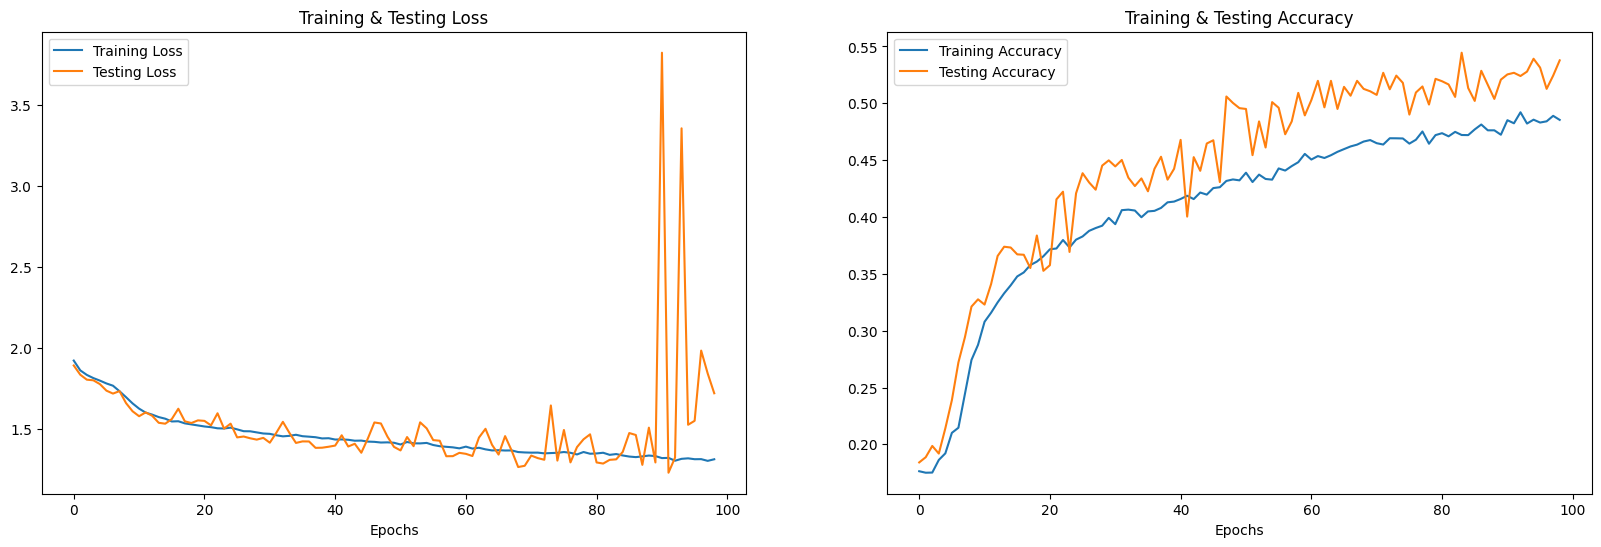

In [32]:
epoch_view(history, num_epochs = len(history.history['loss']))

89/89 [==============================] - 0s 2ms/step


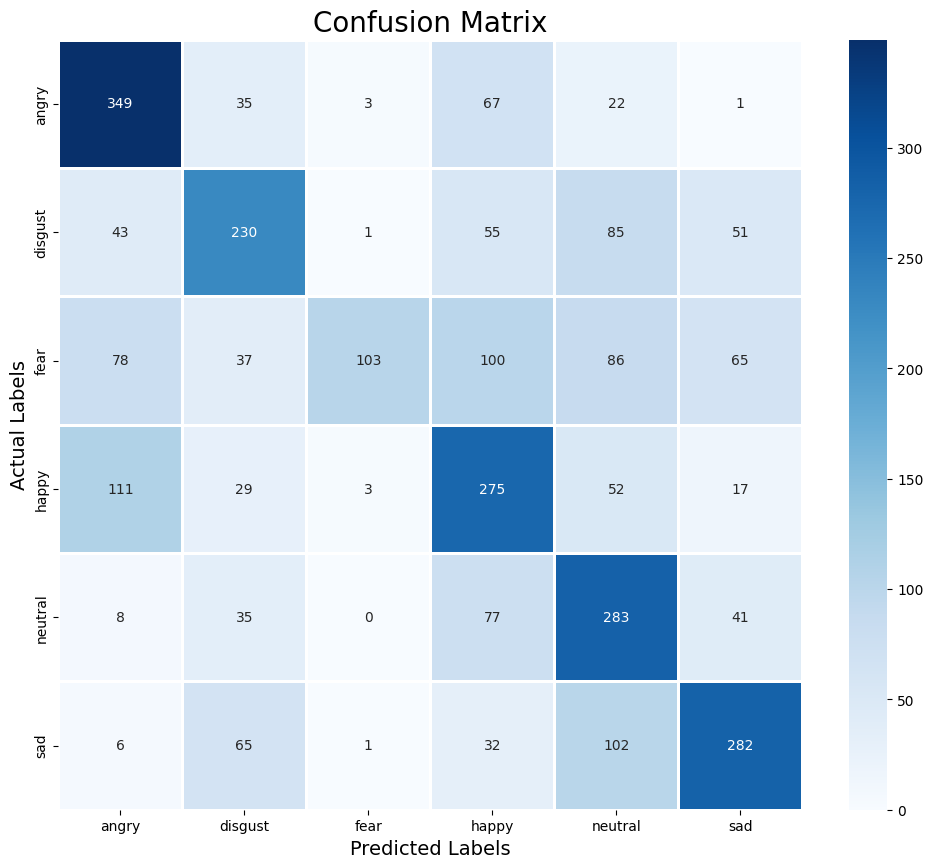

,Predicted Labels,Actual Labels
0,happy,happy
1,happy,fear
2,sad,disgust
3,happy,fear
4,disgust,disgust
5,neutral,neutral
6,happy,happy
7,fear,fear
8,sad,disgust
9,happy,fear


In [33]:
y_pred, y_test = pred_result(large_base_model, x_test, y_test, encoder = encoder, cm_bool = True)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.67      0.63      0.65       477
     disgust       0.59      0.45      0.51       465
        fear       0.52      0.26      0.35       469
       happy       0.42      0.45      0.44       487
     neutral       0.40      0.74      0.52       444
         sad       0.61      0.57      0.59       488

    accuracy                           0.52      2830
   macro avg       0.54      0.52      0.51      2830
weighted avg       0.54      0.52      0.51      2830



### CNN

In [17]:
def cnn_model(nfilters1=32, nfilters2=64, size_kernel=5, nstrides=1, s_pool1=5, s_pool2=5, s_pool3=5):
    model=Sequential()
    model.add(Conv2D(filters=nfilters1, kernel_size=size_kernel, strides=nstrides, padding='same', activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
    #model.add(Dropout(0.2))    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=s_pool1, strides = nstrides, padding = 'same'))

    model.add(Conv2D(filters=nfilters2, kernel_size=size_kernel, strides=nstrides, padding='same', activation='relu'))
    #model.add(Dropout(0.15))
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size=s_pool2, strides = nstrides, padding = 'same'))

    #model.add(Conv1D(filters=nfilters4, kernel_size=size_kernel, strides=nstrides, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.2))    
    model.add(Dense(units=16, activation='relu'))
    model.add(Dropout(0.1))    

    model.add(Dense(units=6, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    #rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.30, verbose=0, patience=2, min_lr=0.0000001)

    #model.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test), callbacks=[rlrp])    
    
    #model.summary()

    return model

### CapNet

In [ ]:
from tensorflow.keras import layers, models

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, capsule_dim, routings=3, kernel_initializer='glorot_uniform', **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.capsule_dim = capsule_dim
        self.routings = routings
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(
            shape=(input_dim, self.num_capsules, self.capsule_dim),
            initializer=self.kernel_initializer,
            trainable=True,
        )

    def call(self, inputs):
        # Inputs shape: (batch_size, input_dim, input_num_capsules)
        # W shape: (input_dim, num_capsules, capsule_dim)
        # u_hat: (batch_size, input_dim, num_capsules, capsule_dim)
        u_hat = tf.matmul(inputs, self.W)
        
        # Initialize b with zero values
        b = tf.zeros((inputs.shape[0], input_dim, self.num_capsules))
        
        # Routing algorithm
        for _ in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            s = tf.reduce_sum(c * u_hat, axis=1)
            v = squash(s)
            b += tf.reduce_sum(u_hat * v[:, tf.newaxis, :, :], axis=-1)

        return v
    
def squash(vector):
    vector_norm = tf.norm(vector, axis=-1, keepdims=True)
    vector_squashed = (vector_norm / (1 + vector_norm**2)) * vector
    return vector_squashed

def cn_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(x_train.shape[1:])))  # Input shape
    model.add(CapsuleLayer(num_capsules=10, capsule_dim=16))  # Primary Capsules
    model.add(CapsuleLayer(num_capsules=10, capsule_dim=16))  # Digit Capsules
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model


In [ ]:

cn_model().fit(x_train, y_train, batch_size=16, epochs=20, validation_data=(x_test, y_test))


### SepTr